In [1]:
import os
os.listdir("raw_dat")


['pkt-stats-cell-1.dat',
 'pkt-stats-cell-10.dat',
 'pkt-stats-cell-11.dat',
 'pkt-stats-cell-12.dat',
 'pkt-stats-cell-13.dat',
 'pkt-stats-cell-14.dat',
 'pkt-stats-cell-15.dat',
 'pkt-stats-cell-16.dat',
 'pkt-stats-cell-17.dat',
 'pkt-stats-cell-18.dat',
 'pkt-stats-cell-19.dat',
 'pkt-stats-cell-2.dat',
 'pkt-stats-cell-20.dat',
 'pkt-stats-cell-21.dat',
 'pkt-stats-cell-22.dat',
 'pkt-stats-cell-23.dat',
 'pkt-stats-cell-24.dat',
 'pkt-stats-cell-3.dat',
 'pkt-stats-cell-4.dat',
 'pkt-stats-cell-5.dat',
 'pkt-stats-cell-6.dat',
 'pkt-stats-cell-7.dat',
 'pkt-stats-cell-8.dat',
 'pkt-stats-cell-9.dat',
 'throughput-cell-1.dat',
 'throughput-cell-10.dat',
 'throughput-cell-11.dat',
 'throughput-cell-12.dat',
 'throughput-cell-13.dat',
 'throughput-cell-14.dat',
 'throughput-cell-15.dat',
 'throughput-cell-16.dat',
 'throughput-cell-17.dat',
 'throughput-cell-18.dat',
 'throughput-cell-19.dat',
 'throughput-cell-2.dat',
 'throughput-cell-20.dat',
 'throughput-cell-21.dat',
 'through

In [2]:
filename = "pkt-stats-cell-1.dat"

with open(f"raw_dat/{filename}") as f:
    for i in range(10):
        print(f.readline())


<slot> <slotStart> <txPackets> <rxPackets> <tooLateRxPackets>

1.00001 0 0 0

1.00023 0 0 0

1.00065 0 0 0

1.00115 0 0 0

1.00215 0 0 0

1.00265 0 0 0

1.00315 0 0 0

1.00365 0 0 0

1.00465 16 16 0



In [3]:
import json


In [4]:
with open("json_output/cell_1_pkt_stats.json") as f:
    data = json.load(f)

len(data)


91606

In [5]:
congestion_vector = [
    1 if row["tooLateRxPackets"] > 0 else 0
    for row in data
]

congestion_vector[:30]


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [6]:
sum(congestion_vector), len(congestion_vector)


(0, 91606)

In [7]:
filename = "pkt-stats-cell-2.dat"

records_2 = []

with open(f"raw_dat/{filename}") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("<"):
            continue

        parts = line.split()
        if len(parts) != 4:
            continue

        records_2.append({
            "slot": float(parts[0]),
            "txPackets": int(parts[1]),
            "rxPackets": int(parts[2]),
            "tooLateRxPackets": int(parts[3]),
        })

len(records_2)


91606

In [8]:
congestion_vector_2 = [
    1 if row["tooLateRxPackets"] > 0 else 0
    for row in records_2
]

sum(congestion_vector_2), len(congestion_vector_2)


(0, 91606)

In [9]:
min_len = min(len(congestion_vector), len(congestion_vector_2))

c1 = congestion_vector[:min_len]
c2 = congestion_vector_2[:min_len]


In [10]:
import numpy as np
np.__version__


'2.4.1'

In [11]:
# Cell 1 congestion vector (already created earlier)
c1 = congestion_vector

# Cell 2 congestion vector
c2 = congestion_vector_2

# align lengths
min_len = min(len(c1), len(c2))
c1 = c1[:min_len]
c2 = c2[:min_len]


In [12]:
import numpy as np

if np.std(c1) == 0 or np.std(c2) == 0:
    corr = 0
else:
    corr = np.corrcoef(c1, c2)[0, 1]

corr


0

In [13]:
import os
import json

cell_congestion = {}

for filename in os.listdir("raw_dat"):
    if not filename.startswith("pkt-stats-cell"):
        continue

    cell_id = filename.replace("pkt-stats-", "").replace(".dat", "")

    records = []
    with open(f"raw_dat/{filename}") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("<"):
                continue

            parts = line.split()
            if len(parts) != 4:
                continue

            records.append({
                "late": int(parts[3])
            })

    congestion_vector = [
        1 if r["late"] > 0 else 0
        for r in records
    ]

    cell_congestion[cell_id] = congestion_vector

len(cell_congestion)


24

In [14]:
import numpy as np

cells = list(cell_congestion.keys())
correlation_matrix = {}

for i in range(len(cells)):
    for j in range(i + 1, len(cells)):
        c1 = cell_congestion[cells[i]]
        c2 = cell_congestion[cells[j]]

        min_len = min(len(c1), len(c2))
        c1 = c1[:min_len]
        c2 = c2[:min_len]

        if np.std(c1) == 0 or np.std(c2) == 0:
            corr = 0
        else:
            corr = np.corrcoef(c1, c2)[0, 1]

        correlation_matrix[(cells[i], cells[j])] = corr

list(correlation_matrix.items())[:5]


[(('cell-1', 'cell-10'), 0),
 (('cell-1', 'cell-11'), 0),
 (('cell-1', 'cell-12'), 0),
 (('cell-1', 'cell-13'), 0),
 (('cell-1', 'cell-14'), 0)]

In [15]:
THRESHOLD = 0.7

links = []
used = set()

for cell in cells:
    if cell in used:
        continue

    group = [cell]
    used.add(cell)

    for other in cells:
        if other in used or other == cell:
            continue

        key = (cell, other) if (cell, other) in correlation_matrix else (other, cell)
        corr = correlation_matrix.get(key, 0)

        if corr > THRESHOLD:
            group.append(other)
            used.add(other)

    links.append(group)

links


[['cell-1'],
 ['cell-10'],
 ['cell-11'],
 ['cell-12'],
 ['cell-13'],
 ['cell-14'],
 ['cell-15'],
 ['cell-16'],
 ['cell-17'],
 ['cell-18'],
 ['cell-19'],
 ['cell-2'],
 ['cell-20'],
 ['cell-21'],
 ['cell-22'],
 ['cell-23'],
 ['cell-24'],
 ['cell-3'],
 ['cell-4'],
 ['cell-5'],
 ['cell-6'],
 ['cell-7'],
 ['cell-8'],
 ['cell-9']]

In [16]:
cell_signal = {}

for filename in os.listdir("raw_dat"):
    if not filename.startswith("pkt-stats-cell"):
        continue

    cell_id = filename.replace("pkt-stats-", "").replace(".dat", "")
    tx_values = []

    with open(f"raw_dat/{filename}") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("<"):
                continue

            parts = line.split()
            if len(parts) != 4:
                continue

            tx_values.append(int(parts[1]))

    # dynamic congestion threshold (90th percentile)
    threshold = np.percentile(tx_values, 90)

    congestion_signal = [
        1 if tx > threshold else 0
        for tx in tx_values
    ]

    cell_signal[cell_id] = congestion_signal

len(cell_signal)


24

In [17]:
cells = list(cell_signal.keys())
correlation_matrix = {}

for i in range(len(cells)):
    for j in range(i + 1, len(cells)):
        c1 = cell_signal[cells[i]]
        c2 = cell_signal[cells[j]]

        min_len = min(len(c1), len(c2))
        c1 = c1[:min_len]
        c2 = c2[:min_len]

        if np.std(c1) == 0 or np.std(c2) == 0:
            corr = 0
        else:
            corr = np.corrcoef(c1, c2)[0, 1]

        correlation_matrix[(cells[i], cells[j])] = corr


In [18]:
THRESHOLD = 0.6

links = []
used = set()

for cell in cells:
    if cell in used:
        continue

    group = [cell]
    used.add(cell)

    for other in cells:
        if other in used or other == cell:
            continue

        key = (cell, other) if (cell, other) in correlation_matrix else (other, cell)
        corr = correlation_matrix.get(key, 0)

        if corr > THRESHOLD:
            group.append(other)
            used.add(other)

    links.append(group)

links


[['cell-1'],
 ['cell-10'],
 ['cell-11'],
 ['cell-12'],
 ['cell-13'],
 ['cell-14'],
 ['cell-15'],
 ['cell-16'],
 ['cell-17'],
 ['cell-18'],
 ['cell-19'],
 ['cell-2'],
 ['cell-20'],
 ['cell-21'],
 ['cell-22'],
 ['cell-23'],
 ['cell-24'],
 ['cell-3'],
 ['cell-4'],
 ['cell-5'],
 ['cell-6'],
 ['cell-7'],
 ['cell-8'],
 ['cell-9']]

In [19]:
import os
os.listdir("raw_dat")


['pkt-stats-cell-1.dat',
 'pkt-stats-cell-10.dat',
 'pkt-stats-cell-11.dat',
 'pkt-stats-cell-12.dat',
 'pkt-stats-cell-13.dat',
 'pkt-stats-cell-14.dat',
 'pkt-stats-cell-15.dat',
 'pkt-stats-cell-16.dat',
 'pkt-stats-cell-17.dat',
 'pkt-stats-cell-18.dat',
 'pkt-stats-cell-19.dat',
 'pkt-stats-cell-2.dat',
 'pkt-stats-cell-20.dat',
 'pkt-stats-cell-21.dat',
 'pkt-stats-cell-22.dat',
 'pkt-stats-cell-23.dat',
 'pkt-stats-cell-24.dat',
 'pkt-stats-cell-3.dat',
 'pkt-stats-cell-4.dat',
 'pkt-stats-cell-5.dat',
 'pkt-stats-cell-6.dat',
 'pkt-stats-cell-7.dat',
 'pkt-stats-cell-8.dat',
 'pkt-stats-cell-9.dat',
 'throughput-cell-1.dat',
 'throughput-cell-10.dat',
 'throughput-cell-11.dat',
 'throughput-cell-12.dat',
 'throughput-cell-13.dat',
 'throughput-cell-14.dat',
 'throughput-cell-15.dat',
 'throughput-cell-16.dat',
 'throughput-cell-17.dat',
 'throughput-cell-18.dat',
 'throughput-cell-19.dat',
 'throughput-cell-2.dat',
 'throughput-cell-20.dat',
 'throughput-cell-21.dat',
 'through

In [20]:
import os
import numpy as np

cell_signal = {}

for i in range(1, 25):
    cell_id = f"cell-{i}"

    pkt_file = f"raw_dat/pkt-stats-{cell_id}.dat"
    thr_file = f"raw_dat/throughput-{cell_id}.dat"

    pkt_late = []
    throughput = []

    # ---- read packet stats (RU side) ----
    with open(pkt_file) as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("<"):
                continue
            parts = line.split()
            pkt_late.append(int(parts[3]))  # tooLateRxPackets

    # ---- read throughput (DU side) ----
    with open(thr_file) as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("<"):
                continue
            parts = line.split()
            throughput.append(float(parts[1]))  # throughput value

    # ---- align lengths ----
    L = min(len(pkt_late), len(throughput))
    pkt_late = pkt_late[:L]
    throughput = throughput[:L]

    # ---- composite congestion signal ----
    thr_threshold = np.percentile(throughput, 95)

    signal = [
        1 if (pkt_late[j] > 0 or throughput[j] > thr_threshold) else 0
        for j in range(L)
    ]

    cell_signal[cell_id] = signal

len(cell_signal)


24

In [21]:
cells = list(cell_signal.keys())
corr_map = {}

for i in range(len(cells)):
    for j in range(i + 1, len(cells)):
        c1 = cell_signal[cells[i]]
        c2 = cell_signal[cells[j]]

        if np.std(c1) == 0 or np.std(c2) == 0:
            corr = 0
        else:
            corr = np.corrcoef(c1, c2)[0, 1]

        corr_map[(cells[i], cells[j])] = corr

len(corr_map)


276

In [22]:
THRESHOLD = 0.4   # realistic telecom threshold

links = []
used = set()

for cell in cells:
    if cell in used:
        continue

    group = [cell]
    used.add(cell)

    for other in cells:
        if other in used or other == cell:
            continue

        key = (cell, other) if (cell, other) in corr_map else (other, cell)
        if corr_map.get(key, 0) > THRESHOLD:
            group.append(other)
            used.add(other)

    links.append(group)

links


[['cell-1', 'cell-20'],
 ['cell-2'],
 ['cell-3'],
 ['cell-4'],
 ['cell-5'],
 ['cell-6'],
 ['cell-7'],
 ['cell-8'],
 ['cell-9'],
 ['cell-10'],
 ['cell-11'],
 ['cell-12'],
 ['cell-13'],
 ['cell-14'],
 ['cell-15'],
 ['cell-16'],
 ['cell-17'],
 ['cell-18'],
 ['cell-19'],
 ['cell-21'],
 ['cell-22'],
 ['cell-23'],
 ['cell-24']]

In [23]:
# --- Topology result you already got ---
topology_groups = [
    ['cell-1', 'cell-20'],
    ['cell-2'],
    ['cell-3'],
    ['cell-4'],
    ['cell-5'],
    ['cell-6'],
    ['cell-7'],
    ['cell-8'],
    ['cell-9'],
    ['cell-10'],
    ['cell-11'],
    ['cell-12'],
    ['cell-13'],
    ['cell-14'],
    ['cell-15'],
    ['cell-16'],
    ['cell-17'],
    ['cell-18'],
    ['cell-19'],
    ['cell-21'],
    ['cell-22'],
    ['cell-23'],
    ['cell-24']
]

# --- Assign link names ---
links = {}

for i, group in enumerate(topology_groups):
    links[f"Link_{i+1}"] = group

links


{'Link_1': ['cell-1', 'cell-20'],
 'Link_2': ['cell-2'],
 'Link_3': ['cell-3'],
 'Link_4': ['cell-4'],
 'Link_5': ['cell-5'],
 'Link_6': ['cell-6'],
 'Link_7': ['cell-7'],
 'Link_8': ['cell-8'],
 'Link_9': ['cell-9'],
 'Link_10': ['cell-10'],
 'Link_11': ['cell-11'],
 'Link_12': ['cell-12'],
 'Link_13': ['cell-13'],
 'Link_14': ['cell-14'],
 'Link_15': ['cell-15'],
 'Link_16': ['cell-16'],
 'Link_17': ['cell-17'],
 'Link_18': ['cell-18'],
 'Link_19': ['cell-19'],
 'Link_20': ['cell-21'],
 'Link_21': ['cell-22'],
 'Link_22': ['cell-23'],
 'Link_23': ['cell-24']}

In [24]:
import numpy as np

SLOT_TIME_SEC = 0.0005        # 500 microseconds
BUFFER_TIME_SEC = 143e-6     # 143 microseconds (4 symbols)


In [25]:
def load_throughput(cell_id):
    values = []
    with open(f"raw_dat/throughput-{cell_id}.dat") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("<"):
                continue
            parts = line.split()
            values.append(float(parts[1]))  # throughput per symbol/slot
    return values


In [26]:
final_capacity = {}

for link_name, cells_in_link in links.items():

    # Load throughput for each cell in this link
    throughputs = [load_throughput(c) for c in cells_in_link]

    # Align lengths
    min_len = min(len(t) for t in throughputs)
    throughputs = [t[:min_len] for t in throughputs]

    # Aggregate traffic per slot
    aggregated = [
        sum(t[i] for t in throughputs)
        for i in range(min_len)
    ]

    # -------- WITHOUT BUFFER --------
    peak_bits = np.percentile(aggregated, 99)
    capacity_no_buffer = (peak_bits / SLOT_TIME_SEC) / 1e9

    # -------- WITH BUFFER --------
    buffer_bits = BUFFER_TIME_SEC * capacity_no_buffer * 1e9
    effective_peak = max(peak_bits - buffer_bits, 0)
    capacity_with_buffer = (effective_peak / SLOT_TIME_SEC) / 1e9

    final_capacity[link_name] = {
        "cells": cells_in_link,
        "capacity_no_buffer_Gbps": round(capacity_no_buffer, 3),
        "capacity_with_buffer_Gbps": round(capacity_with_buffer, 3)
    }

final_capacity


{'Link_1': {'cells': ['cell-1', 'cell-20'],
  'capacity_no_buffer_Gbps': np.float64(0.001),
  'capacity_with_buffer_Gbps': np.float64(0.001)},
 'Link_2': {'cells': ['cell-2'],
  'capacity_no_buffer_Gbps': np.float64(0.001),
  'capacity_with_buffer_Gbps': np.float64(0.001)},
 'Link_3': {'cells': ['cell-3'],
  'capacity_no_buffer_Gbps': np.float64(0.001),
  'capacity_with_buffer_Gbps': np.float64(0.0)},
 'Link_4': {'cells': ['cell-4'],
  'capacity_no_buffer_Gbps': np.float64(0.001),
  'capacity_with_buffer_Gbps': np.float64(0.0)},
 'Link_5': {'cells': ['cell-5'],
  'capacity_no_buffer_Gbps': np.float64(0.001),
  'capacity_with_buffer_Gbps': np.float64(0.0)},
 'Link_6': {'cells': ['cell-6'],
  'capacity_no_buffer_Gbps': np.float64(0.001),
  'capacity_with_buffer_Gbps': np.float64(0.001)},
 'Link_7': {'cells': ['cell-7'],
  'capacity_no_buffer_Gbps': np.float64(0.001),
  'capacity_with_buffer_Gbps': np.float64(0.001)},
 'Link_8': {'cells': ['cell-8'],
  'capacity_no_buffer_Gbps': np.float6

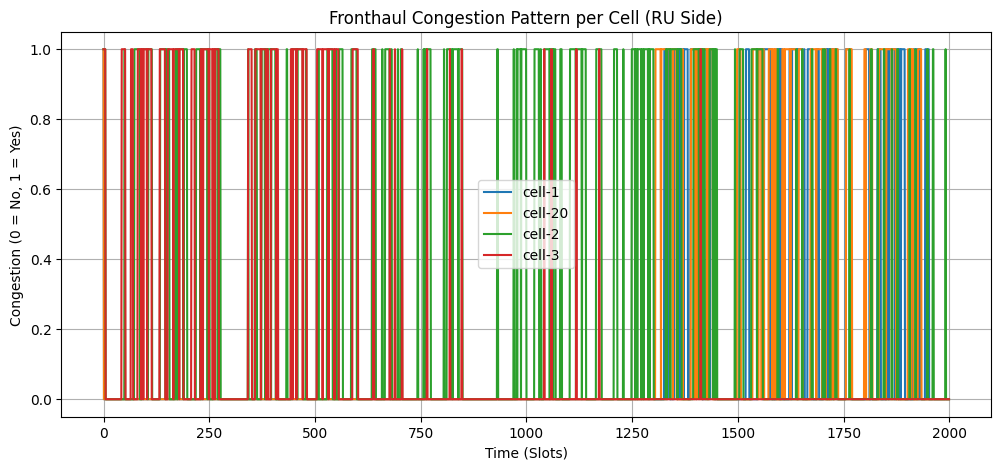

In [27]:
import matplotlib.pyplot as plt

# pick few cells to visualize (important ones)
cells_to_plot = ['cell-1', 'cell-20', 'cell-2', 'cell-3']

plt.figure(figsize=(12, 5))

for cell in cells_to_plot:
    signal = cell_signal[cell]
    plt.plot(signal[:2000], label=cell)  # first 2000 slots

plt.title("Fronthaul Congestion Pattern per Cell (RU Side)")
plt.xlabel("Time (Slots)")
plt.ylabel("Congestion (0 = No, 1 = Yes)")
plt.legend()
plt.grid(True)
plt.show()


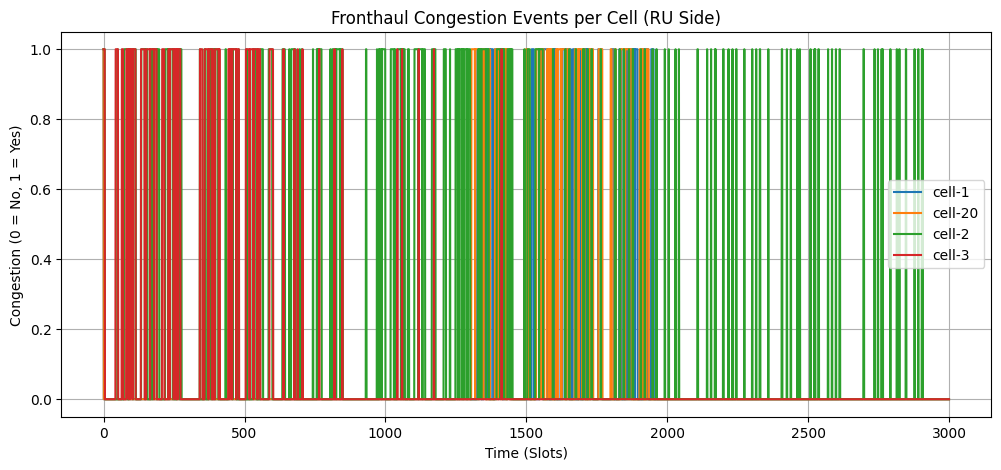

In [28]:
import matplotlib.pyplot as plt

cells_to_plot = ['cell-1', 'cell-20', 'cell-2', 'cell-3']

plt.figure(figsize=(12, 5))

for cell in cells_to_plot:
    signal = cell_signal[cell]
    plt.plot(signal[:3000], label=cell)

plt.title("Fronthaul Congestion Events per Cell (RU Side)")
plt.xlabel("Time (Slots)")
plt.ylabel("Congestion (0 = No, 1 = Yes)")
plt.legend()
plt.grid(True)
plt.show()


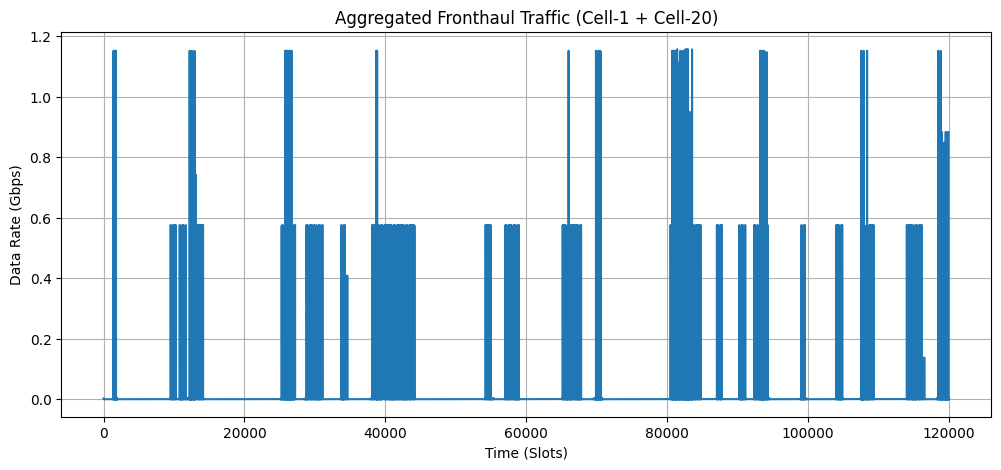

In [29]:
link_cells = ['cell-1', 'cell-20']

throughputs = [load_throughput(c) for c in link_cells]
min_len = min(len(t) for t in throughputs)
throughputs = [t[:min_len] for t in throughputs]

aggregated = [
    sum(t[i] for t in throughputs)
    for i in range(min_len)
]

data_rate_gbps = [(v / SLOT_TIME_SEC) / 1e9 for v in aggregated]

plt.figure(figsize=(12, 5))
plt.plot(data_rate_gbps[:120000])
plt.title("Aggregated Fronthaul Traffic (Cell-1 + Cell-20)")
plt.xlabel("Time (Slots)")
plt.ylabel("Data Rate (Gbps)")
plt.grid(True)
plt.show()


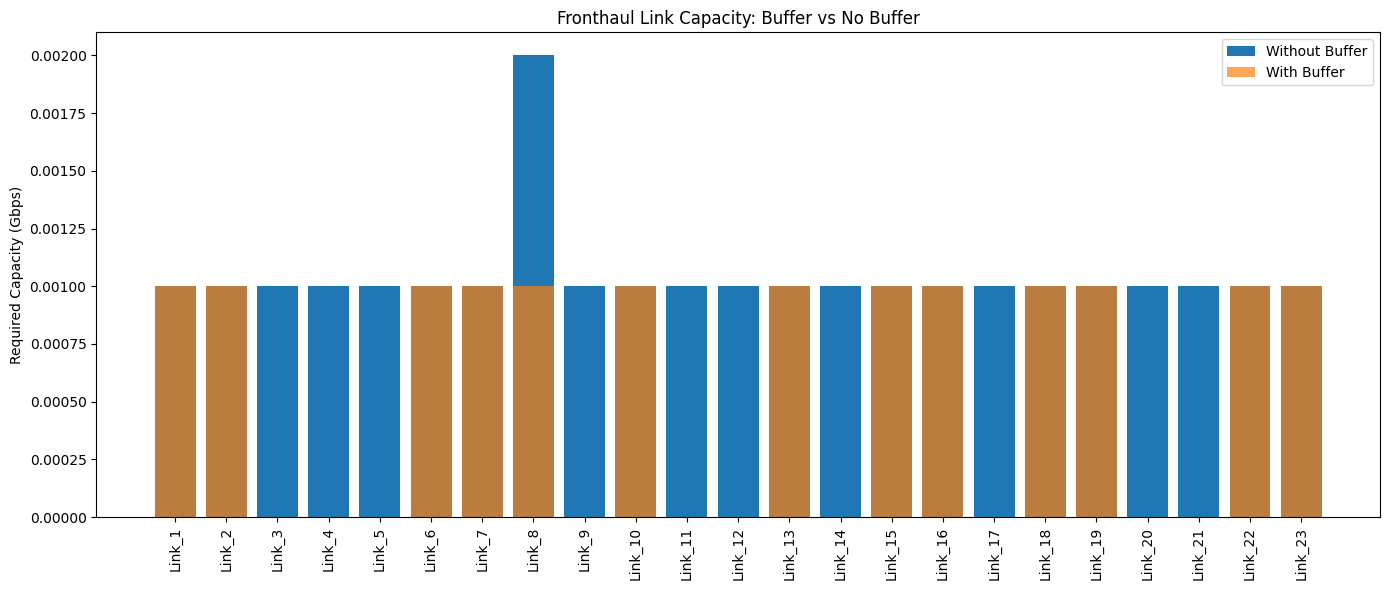

In [30]:
link_names = list(final_capacity.keys())

no_buffer = [
    final_capacity[l]["capacity_no_buffer_Gbps"]
    for l in link_names
]

with_buffer = [
    final_capacity[l]["capacity_with_buffer_Gbps"]
    for l in link_names
]

plt.figure(figsize=(14, 6))
plt.bar(link_names, no_buffer, label="Without Buffer")
plt.bar(link_names, with_buffer, alpha=0.7, label="With Buffer")

plt.xticks(rotation=90)
plt.ylabel("Required Capacity (Gbps)")
plt.title("Fronthaul Link Capacity: Buffer vs No Buffer")
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
import pandas as pd

df = pd.DataFrame.from_dict(final_capacity, orient="index")
df


,cells,capacity_no_buffer_Gbps,capacity_with_buffer_Gbps
Link_1,"[cell-1, cell-20]",0.001,0.001
Link_2,[cell-2],0.001,0.001
Link_3,[cell-3],0.001,0.000
Link_4,[cell-4],0.001,0.000
Link_5,[cell-5],0.001,0.000
Link_6,[cell-6],0.001,0.001
Link_7,[cell-7],0.001,0.001
Link_8,[cell-8],0.002,0.001
Link_9,[cell-9],0.001,0.000
Link_10,[cell-10],0.001,0.001
